### Complejidad - Práctico 4/6 - Generación procedural de terrenos
#### Lautaro Giordano

In [3]:
import numpy as np
from matplotlib import pyplot as plt

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_6156\2499416126.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


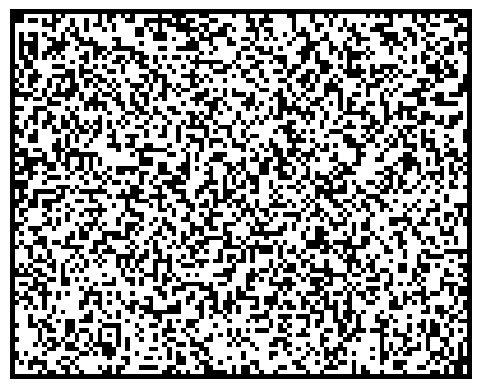

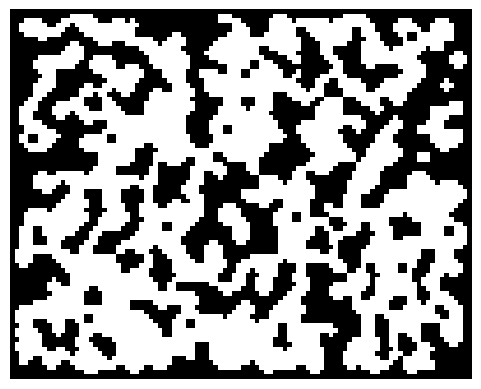

In [63]:
width, height = 80, 100

class cueva:
    def __init__(self, width, height, prob_pared, seed=None):
        self.width = width
        self.height = height
        self.prob_pared = prob_pared
        # El default es seed=None que me da una semilla aleatoria.
        self.seed = seed
        np.random.seed(self.seed)
        self.cueva = self.generar_cueva()
        # self.bordes = self.calcular_bordes()
    

    def generar_cueva(self):
        cueva = np.ones((self.width, self.height))

        # Los bordes siempre son unos (paredes).
        for i in range(1, self.width - 1):
            for j in range(1, self.height - 1):
                cueva[i][j] = 1 if np.random.random() < self.prob_pared else 0
        
        return cueva
       

    def plot_cueva(self):
        fig, ax = plt.subplots()
        ax.imshow(self.cueva, cmap='binary')
        # if bordes:
        #     self.bordes = self.calcular_bordes()
        #     ax.imshow(self.bordes, cmap='Greys')
        # Apago los ejes
        ax.axis('off')
        fig.show()


    def paso_suavizar_cueva(self):
        cueva = self.cueva.copy()
        # No miro los bordes
        for i in range(1, self.width - 1):
            for j in range(1, self.height - 1):
                # Miro a primeros vecinos de una celda
                vecindad = cueva[i-1:i+2, j-1:j+2]
                # Si hay más de 5 celdas con pared, pongo una pared (regla del automata)
                if np.sum(vecindad) >= 5:
                    self.cueva[i][j] = 1
                # Si hay menos de 3 celdas con pared, pongo un espacio vacío
                elif np.sum(vecindad) <= 3:
                    self.cueva[i][j] = 0


    def suavizar_cueva(self, n_its=5):
        for _ in range(n_its):
            self.paso_suavizar_cueva()



cueva = cueva(width, height, 0.4, seed=None)
cueva.plot_cueva()
cueva.suavizar_cueva(5)
cueva.plot_cueva()